# Test for different SME solvers against analytical solution for oscillator squeezing

Manuel Grimm, Niels Lörch, and Denis V. Vasilyev

30 August 2016

We solve the stochastic master equation for an oscillator coupled to a 1D field as discussed in [1]. There is a deterministic differential equation for the variances of the oscillator quadratures $\langle\delta X^2\rangle$ and $\langle\delta P^2\rangle$. This allows for a direct comparison between the numerical solution and the exact solution for a single quantum trajectory. In particular, we study scaling of deviations from analytical solution as a function of stepsize for different solvers:
'euler-maruyama', 'pc-euler', 'milstein', 'milstein-imp', 'taylor15', 'taylor15-imp'.

It is important to check the correct scaling since it is very easy to implement a higher order method in a wrong way such that it still works but as a lower order method.

In this section we solve SME with a single Wiener increment: 
### $\mathrm{d}\rho = D[s]\rho\mathrm{d}t + H[s]\rho \mathrm{d}W + \gamma D[a]\rho\mathrm{d}t$

The steady state solution for the variance $V_{\mathrm{c}} = \langle X^2\rangle - \langle X\rangle^2$ reads

$V_{\mathrm{c}} = \frac1{4\alpha^{2}}\left[\alpha\beta - \gamma + \sqrt{(\gamma-\alpha\beta )^{2} + 4\gamma \alpha^2}\right]$

where $\alpha$ and $\beta$ are parametrizing the interaction between light and the oscillator such that the jump operator is given by $s = \frac{\alpha+\beta}2 a + \frac{\alpha-\beta}2 a^{\dagger}$

[1] D. V. Vasilyev, C. a. Muschik, and K. Hammerer, Physical Review A 87, 053820 (2013). <a href="http://arxiv.org/abs/1303.5888">arXiv:1303.5888</a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Just check that analytical solution coincides with the solution of ODE for the variance

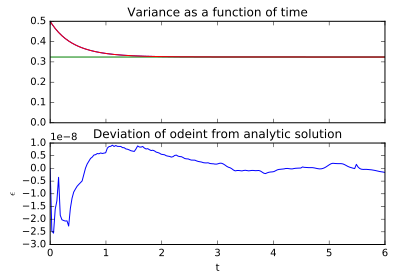

In [2]:
def arccoth(x):
    return 0.5*np.log((1.+x)/(x-1.))

############ parameters #############

th = 0.1 # Interaction parameter
alpha = np.cos(th)
beta = np.sin(th)
gamma = 1.

################# Solution of the differential equation for the variance Vc ####################
T = 6.
N_store = 200
tlist = np.linspace(0,T,N_store)
y0 = 0.5
def func(y, t):
    return -(gamma - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gamma
y = odeint(func, y0, tlist)

############ Exact steady state solution for Vc #########################
Vc = (alpha*beta - gamma + np.sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha**2))/(4*alpha**2)

#### Analytic solution
A = (gamma**2 + alpha**2 * (beta**2 + 4*gamma) - 2*alpha*beta*gamma)**0.5
B = arccoth((-4*alpha**2*y0 + alpha*beta - gamma)/A)
y_an = (alpha*beta - gamma + A / np.tanh(0.5*A*tlist - B))/(4*alpha**2)

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.set_title('Variance as a function of time')
ax.plot(tlist,y)
ax.plot(tlist,Vc*np.ones_like(tlist))
ax.plot(tlist,y_an)
ax.set_ylim(0,0.5)

ax2.set_title('Deviation of odeint from analytic solution')
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\epsilon$')
ax2.plot(tlist,y_an - y.T[0]);

## Test of different SME solvers

In [8]:
####################### Model ###########################

N = 30                 # number of Fock states
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/np.sqrt(2)
H = Id
c_op = [np.sqrt(gamma)*a]
sc_op = [s]
e_op = [x, x*x]
rho0 = fock_dm(N,0)      # initial vacuum state
#sc_len=1                 # one stochastic operator


############## time steps and trajectories ###################

ntraj = 1 #100           # number of trajectories
Nt = 7                   # number of step sizes that we compare

T = 6.                   # final time          
N_store = 200            # number of time steps for which we save the expectation values/density matrix
tlist = np.linspace(0,T,N_store)
ddt = (tlist[1]-tlist[0])

Nsubmax = int(2**(Nt-1))            # Number of intervals for the smallest step size; 
                                    
dtmin = (tlist[1]-tlist[0])/(Nsubmax)
stepsizes = [ddt/Nsubmax * 2**j for j in range(0,Nt)]   # step size is doubled after each evaluation 



################## initialize variables (absolute error and standard deviation) ###############
# this could also be done using lists such that initialization is not necesarry

epsilon_euler = np.zeros(Nt)
epsilon_mil = np.zeros(Nt)
epsilon_taylor15 = np.zeros(Nt)
epsilon_mil_imp = np.zeros(Nt)
epsilon_taylor15_imp = np.zeros(Nt)
epsilon_pc = np.zeros(Nt)

std_euler = np.zeros(Nt)
std_mil = np.zeros(Nt)
std_taylor15 = np.zeros(Nt)
std_mil_imp = np.zeros(Nt)
std_taylor15_imp = np.zeros(Nt)
std_pc = np.zeros(Nt)



##################  numerical solution ##############################

for j in range(0,ntraj):
   
    
    for jj in range(0,Nt):
        
        Nsub = int(Nsubmax/(2**jj))  
        
        ### Euler Method
        if jj < Nt-1:        # "if loop" is implemented because method diverges for the largest step size used
            
            sol_euler = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                    nsubsteps=Nsub, method='homodyne', solver = 'euler-maruyama')
            
            # absolute error averaged over the time; we approximate the integral as a sum
            epsilon_euler_j = 1/T * np.sum(np.abs(y_an - (sol_euler.expect[1]-sol_euler.expect[0]*sol_euler.expect[0].conj())))*ddt
            epsilon_euler[jj] += epsilon_euler_j
            std_euler[jj] += epsilon_euler_j**2
        
        
        
        
        ### Milstein Method
        if jj < Nt-1:        # "if loop" is implemented because method diverges for the largest step size used     
            sol_mil = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver = 'milstein')

            epsilon_mil_j = 1/T * np.sum(np.abs(y_an - (sol_mil.expect[1]-sol_mil.expect[0]*sol_mil.expect[0].conj())))*ddt
            epsilon_mil[jj] += epsilon_mil_j
            std_mil[jj] += epsilon_mil_j**2
        
        
        
        
        ### Taylor 1.5 Method
        if jj < Nt-1:        # "if loop" is implemented because method diverges for the largest step size used
            sol_taylor15 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver = 'taylor15')

            epsilon_taylor15_j = 1/T * np.sum(np.abs(y_an - (sol_taylor15.expect[1]-sol_taylor15.expect[0]*sol_taylor15.expect[0].conj())))*ddt
            epsilon_taylor15[jj] += epsilon_taylor15_j
            std_taylor15[jj] += epsilon_taylor15_j**2
        
         
        
        
        ### Milstein semi-implicit
        sol_mil_imp = smesolve(H, rho0, tlist, c_op, sc_op, e_op, nsubsteps=Nsub,
                           method='homodyne', solver = 'milstein-imp', args = {'tol':1e-7})
        
        epsilon_mil_imp_j = 1/T * np.sum(np.abs(y_an - (sol_mil_imp.expect[1]-sol_mil_imp.expect[0]*sol_mil_imp.expect[0].conj())))*ddt
        epsilon_mil_imp[jj] += epsilon_mil_imp_j
        std_mil_imp[jj] += epsilon_mil_imp_j**2
        
        
        
        
        ### Taylor 1.5 semi-implicit
        sol_taylor15_imp = smesolve(H, rho0, tlist, c_op, sc_op, e_op, nsubsteps=Nsub,
                           method='homodyne', solver = 'taylor15-imp', args = {'tol':1e-7})
        
        epsilon_taylor15_imp_j = 1/T * np.sum(np.abs(y_an - (sol_taylor15_imp.expect[1]-sol_taylor15_imp.expect[0]*sol_taylor15_imp.expect[0].conj())))*ddt
        epsilon_taylor15_imp[jj] += epsilon_taylor15_imp_j
        std_taylor15_imp[jj] += epsilon_taylor15_imp_j**2
        
        
        ### P-C
        if jj < Nt-1:        # "if loop" is implemented because method diverges for the largest step size used 
            sol_pc = smesolve(H, rho0, tlist, c_op, sc_op, e_op, nsubsteps=Nsub,
                               method='homodyne', solver = 'pc-euler')

            epsilon_pc_j = 1/T * np.sum(np.abs(y_an - (sol_pc.expect[1]-sol_pc.expect[0]*sol_pc.expect[0].conj())))*ddt
            epsilon_pc[jj] += epsilon_pc_j
            std_pc[jj] += epsilon_pc_j**2
 
        

epsilon_euler /= ntraj
epsilon_mil /= ntraj
epsilon_taylor15 /= ntraj
epsilon_mil_imp /= ntraj
epsilon_taylor15_imp /= ntraj
epsilon_pc /= ntraj



std_euler = np.sqrt(1/ntraj * (1/ntraj * std_euler - epsilon_euler**2))
std_mil = np.sqrt(1/ntraj * (1/ntraj * std_mil - epsilon_mil**2))
std_taylor15 = np.sqrt(1/ntraj * (1/ntraj * std_taylor15 - epsilon_taylor15**2))
std_mil_imp = np.sqrt(1/ntraj * (1/ntraj * std_mil_imp - epsilon_mil_imp**2))
std_taylor15_imp = np.sqrt(1/ntraj * (1/ntraj * std_taylor15_imp - epsilon_taylor15_imp**2))                                
std_pc = np.sqrt(1/ntraj * (1/ntraj * std_pc - epsilon_pc**2))

Total run time:  18.31s
Total run time:  74.21s
Total run time:  11.87s
Total run time:  12.40s
Total run time:  18.46s
Total run time:   7.91s
Total run time:   9.82s
Total run time:  45.28s
Total run time:   4.56s
Total run time:   6.03s
Total run time:   8.89s
Total run time:   3.69s
Total run time:   4.43s
Total run time:  17.18s
Total run time:   2.30s
Total run time:   3.12s
Total run time:   4.27s
Total run time:   1.85s
Total run time:   2.30s
Total run time:   8.61s
Total run time:   1.24s
Total run time:   1.61s
Total run time:   2.24s
Total run time:   0.93s
Total run time:   1.20s
Total run time:   4.38s
Total run time:   0.62s
Total run time:   0.89s
Total run time:   1.27s
Total run time:   0.48s
Total run time:   0.56s
Total run time:   2.24s
Total run time:   0.38s
Total run time:   0.48s
Total run time:   0.64s
Total run time:   0.23s
Total run time:   0.31s
Total run time:   0.44s


## Plotting the figure

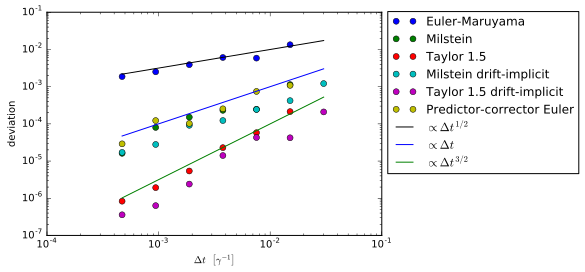

In [9]:
fig = plt.figure()
ax = plt.subplot(111)


######### error bar plot (standard deviation is so small that this is not needed) ###########
#  ax.errorbar(stepsizes, epsilon_euler, yerr = std_euler, fmt='.', label='Euler-Maruyama')
#  ax.errorbar(stepsizes, epsilon_mil,  yerr = std_mil, fmt='.',label="Milstein")
#  ax.errorbar(stepsizes, epsilon_taylor15,  yerr = std_taylor15, fmt='.', label="Taylor 1.5")
#  ax.errorbar(stepsizes, epsilon_mil_imp, yerr = std_mil_imp, fmt='.', label="Milstein drift-implicit")
#  ax.errorbar(stepsizes, epsilon_taylor15_imp, yerr = std_taylor15_imp, fmt='.', label="Taylor 1.5 drift-implicit")
#  ax.errorbar(stepsizes, epsilon_pc, yerr = std_pc, fmt='.', label="Predictor-corrector Euler")
#  ax.set_yscale('log')
#  ax.set_xscale('log')


########## loglog-plot for the mean error as a function of the step size ############
ax.loglog(stepsizes, epsilon_euler, 'o', label='Euler-Maruyama')
ax.loglog(stepsizes, epsilon_mil, 'o',label="Milstein")
ax.loglog(stepsizes, epsilon_taylor15,  'o', label="Taylor 1.5")
ax.loglog(stepsizes, epsilon_mil_imp, 'o',label="Milstein drift-implicit")
ax.loglog(stepsizes, epsilon_taylor15_imp,  'o', label="Taylor 1.5 drift-implicit")
ax.loglog(stepsizes, epsilon_pc,  'o', label="Predictor-corrector Euler")

ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")

ax.set_xlabel(r'$\Delta t$  $\left[\gamma^{-1}\right]$')
ax.set_ylabel('deviation')

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Versions

In [7]:
from qutip.ipynbtools import version_table

version_table()

E:\Miniconda2\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Software,Version
QuTiP,None
Numpy,1.11.1
SciPy,0.18.0
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:42:13) [MSC v.1500 32 bit (Intel)]"
OS,nt [win32]
